## Overfit and underfit

# Setup

In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [0]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jtrbsqfy
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-jtrbsqfy
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dabf76b83baecfcf23243d7bed1dce80bed7883a_-cp36-none-any.whl size=101447 sha256=7f264118f0aad9da4c9a196b66c57e6af8aeabb02c9aae2a6ec7568eada41f03
  Stored in directory: /tmp/pip-ephem-wheel-cache-s0hlqft3/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
logDir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logDir, ignore_errors=True)

# The Higgs Dataset

In [0]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 60s 0us/step


In [0]:
FEATURES = 28

In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [0]:
def packRow(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [0]:
packedDs = ds.batch(10000).map(packRow).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


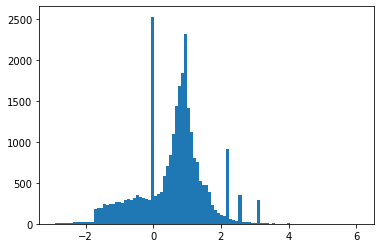

In [0]:
for features,label in packedDs.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [0]:
validateDs = packedDs.take(N_VALIDATION).cache()
trainDs = packedDs.skip(N_VALIDATION).take(N_TRAIN).cache()

In [0]:
trainDs

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validateDs = validateDs.batch(BATCH_SIZE)
trainDs = trainDs.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# Demonstrate overfitting

# Training procedure

In [0]:
lrSchedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def getOptimizer():
  return tf.keras.optimizers.Adam(lrSchedule)

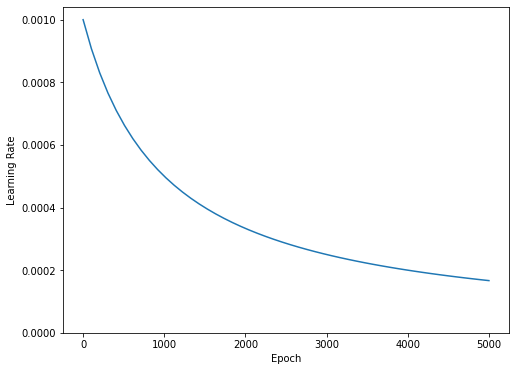

In [0]:
step = np.linspace(0,100000)
lr = lrSchedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [0]:
def getCallbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logDir/name),
  ]

In [0]:
def compileAndFit(model, name, optimizer=None, max_epochs=5000):
  if optimizer is None:
    optimizer = getOptimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    trainDs,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validateDs,
    callbacks=getCallbacks(name),
    verbose=0)
  return history

# Tiny model

In [0]:
tinyModel = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [0]:
sizeHistory = {}

In [0]:
sizeHistory['Tiny'] = compileAndFit(tinyModel, 'sizes/Tiny')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5021,  binary_crossentropy:0.7895,  loss:0.7895,  val_accuracy:0.5250,  val_binary_crossentropy:0.7369,  val_loss:0.7369,  
....................................................................................................
Epoch: 100, accuracy:0.6067,  binary_crossentropy:0.6229,  loss:0.6229,  val_accuracy:0.5830,  val_binary_crossentropy:0.6245,  val_loss:0.6245,  
....................................................................................................
Epoch: 200, accuracy:0.